Vision Transformer (ViT) Architecture

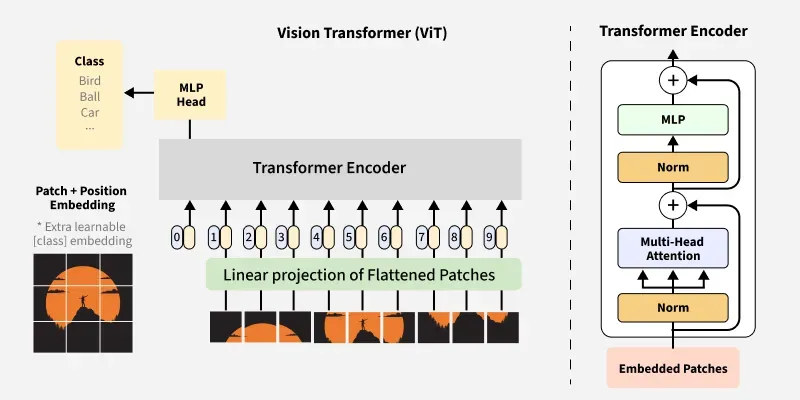

ViT architecture Equations 

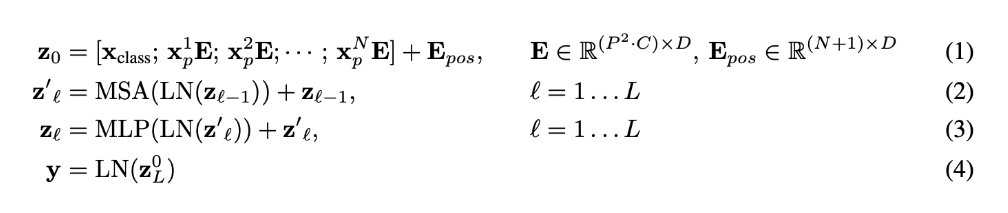

In [1]:
import torch
import torch.nn as nn
import torchvision
import pathlib as Path
import matplotlib.pyplot as plt
import random
from helper_functions import set_seeds

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from pathlib import Path

data_path = Path("data/")

image_path = data_path / "pizza_steak_sushi"

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [4]:
from torchvision import transforms
from going_modular import data_setup

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [5]:
# create data loaders

BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1eba65e2890>,
 ['pizza', 'steak', 'sushi'])

In [6]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

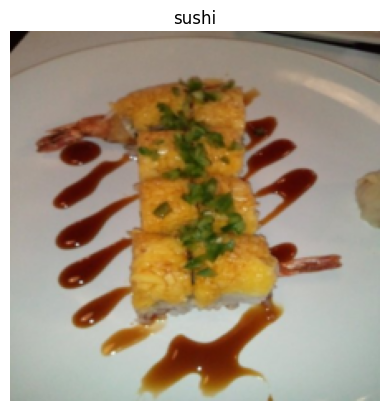

In [7]:
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

In [8]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


Break image to patches

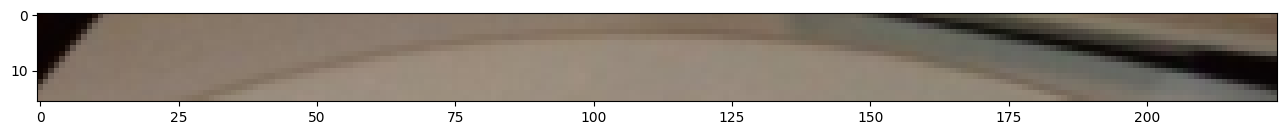

In [9]:
image_permuted = image.permute(1, 2, 0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


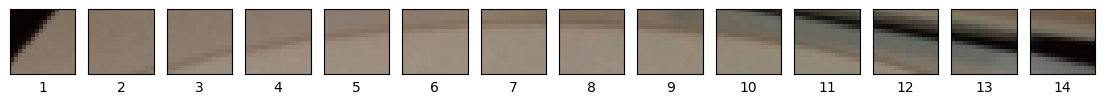

In [10]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); 
    axs[i].set_xlabel(i+1) 
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


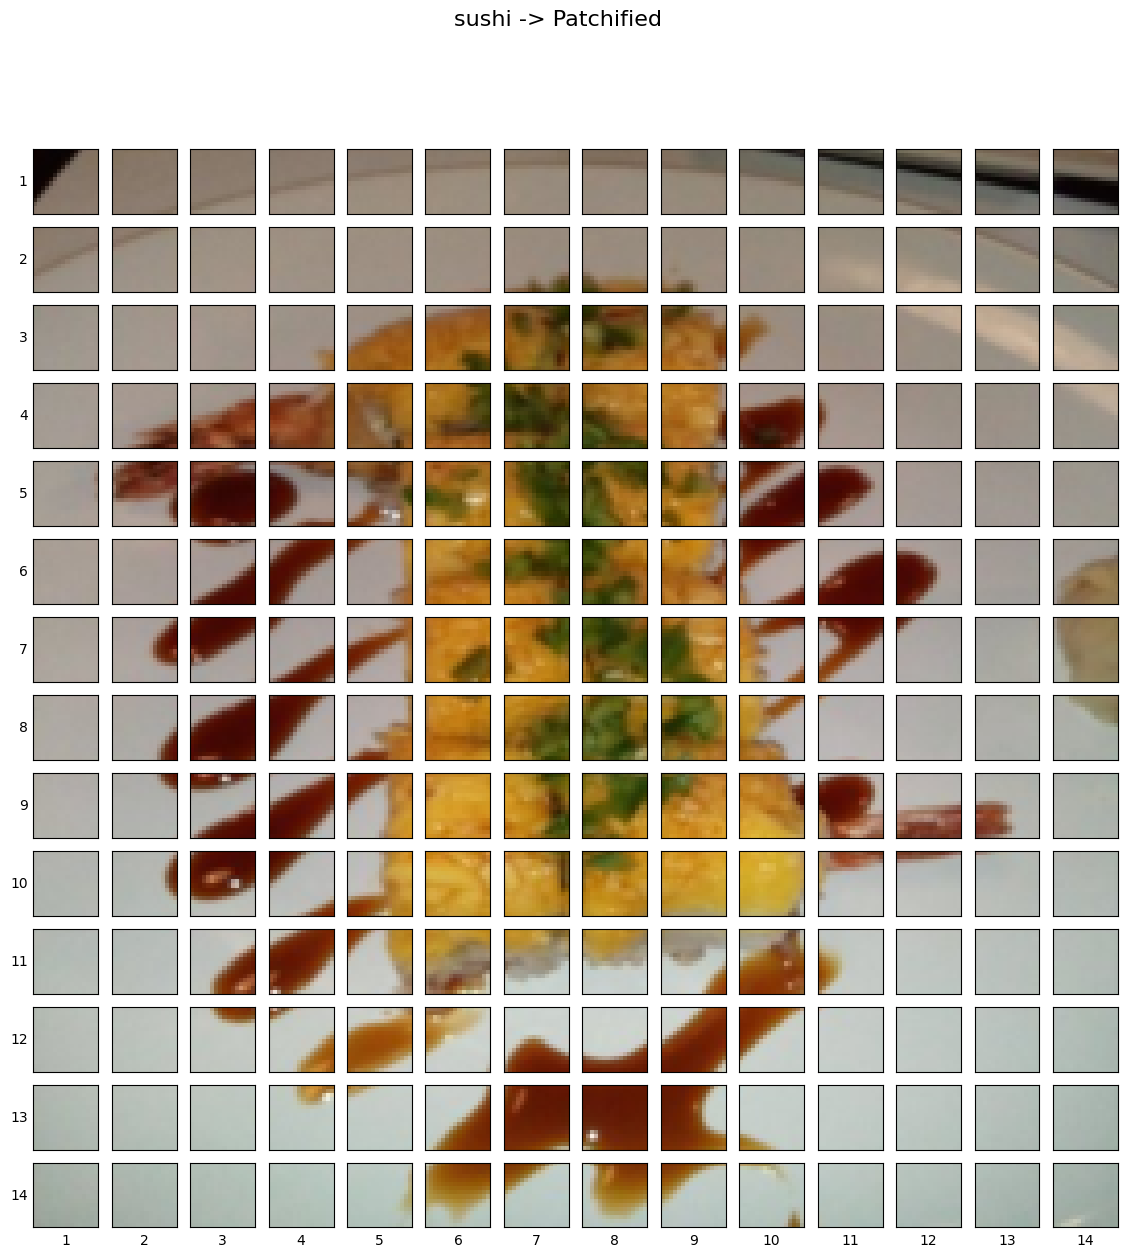

In [11]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, 
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

Create Patch Embeddings

In [12]:
patch_size = 16

conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [13]:
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [411, 481, 512, 258, 153]


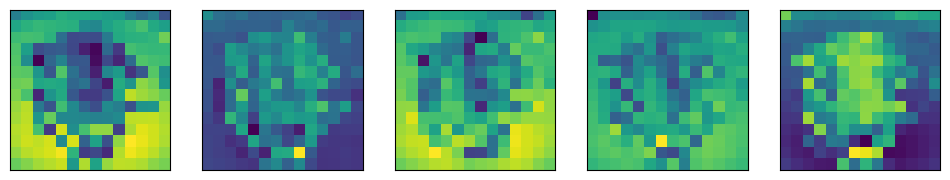

In [14]:
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

Flattening the patch embedding

In [15]:
# Current tensor shape.
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [16]:
# Create flatten layer
flatten_layer = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3)  # flatten feature_map_width (dimension 3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


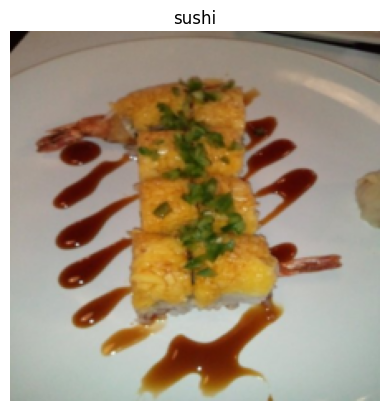

In [17]:
# View single image

plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [18]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(-0.5, 195.5, 0.5, -0.5)

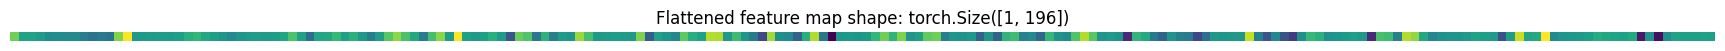

In [19]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

Create patch embedding layer with pytorch 

In [20]:
class PatchEmbedding(nn.Module):
    
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768):
        
        super().__init__()

        self.patch_size = patch_size  
        self.embedding_dim = embedding_dim  

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        image_resolution = x.shape[-1]

        assert image_resolution % self.patch_size == 0, (
            f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        )

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)  

In [21]:
set_seeds(42)

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) 
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [22]:
# random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# patchify(torch.rand(random_input_image_error)) 

Creating the class token embedding

In [23]:
patch_embedded_image, patch_embedded_image.shape

(tensor([[[-0.5254,  0.2056, -0.2077,  ...,  0.3505, -0.0469, -0.0133],
          [-0.5223,  0.1200, -0.1548,  ...,  0.3773, -0.2363,  0.1875],
          [-0.5621,  0.1285, -0.1710,  ...,  0.3814, -0.2381,  0.2073],
          ...,
          [-0.7401,  0.2063, -0.2150,  ...,  0.5708, -0.3437,  0.2589],
          [-0.7005,  0.1956, -0.2076,  ...,  0.5517, -0.3336,  0.2492],
          [-0.6810,  0.1825, -0.2104,  ...,  0.5387, -0.3178,  0.2577]]],
        grad_fn=<PermuteBackward0>),
 torch.Size([1, 196, 768]))

In [24]:
# Get the batch size and embedding dimension.

batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure the embedding is learnable

print(class_token[:, :, :10])

print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [25]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension


print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5254,  0.2056, -0.2077,  ...,  0.3505, -0.0469, -0.0133],
         [-0.5223,  0.1200, -0.1548,  ...,  0.3773, -0.2363,  0.1875],
         ...,
         [-0.7401,  0.2063, -0.2150,  ...,  0.5708, -0.3437,  0.2589],
         [-0.7005,  0.1956, -0.2076,  ...,  0.5517, -0.3336,  0.2492],
         [-0.6810,  0.1825, -0.2104,  ...,  0.5387, -0.3178,  0.2577]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Creating the position embedding

In [26]:
# View the sequence of patch embeddings with the prepended class embedding

patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5254,  0.2056, -0.2077,  ...,  0.3505, -0.0469, -0.0133],
          [-0.5223,  0.1200, -0.1548,  ...,  0.3773, -0.2363,  0.1875],
          ...,
          [-0.7401,  0.2063, -0.2150,  ...,  0.5708, -0.3437,  0.2589],
          [-0.7005,  0.1956, -0.2076,  ...,  0.5517, -0.3336,  0.2492],
          [-0.6810,  0.1825, -0.2104,  ...,  0.5387, -0.3178,  0.2577]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [27]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # create a learnable parameter

print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [28]:
# Add the position embedding to the patch and class token embedding

patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4746, 1.2056, 0.7923,  ..., 1.3505, 0.9531, 0.9867],
         [0.4777, 1.1200, 0.8452,  ..., 1.3773, 0.7637, 1.1875],
         ...,
         [0.2599, 1.2063, 0.7850,  ..., 1.5708, 0.6563, 1.2589],
         [0.2995, 1.1956, 0.7924,  ..., 1.5517, 0.6664, 1.2492],
         [0.3190, 1.1825, 0.7896,  ..., 1.5387, 0.6822, 1.2577]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [29]:
set_seeds()

# Set patch size
patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# Create patch embedding layer.
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


Replicating Equation 2 with PyTorch layers

In [30]:
class MultiheadSelfAttentionBlock(nn.Module):
    
    # Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        
        super().__init__()

        # Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [31]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [32]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4746, 1.2056, 0.7923,  ..., 1.3505, 0.9531, 0.9867],
         [0.4777, 1.1200, 0.8452,  ..., 1.3773, 0.7637, 1.1875],
         ...,
         [0.2599, 1.2063, 0.7850,  ..., 1.5708, 0.6563, 1.2589],
         [0.2995, 1.1956, 0.7924,  ..., 1.5517, 0.6664, 1.2492],
         [0.3190, 1.1825, 0.7896,  ..., 1.5387, 0.6822, 1.2577]]],
       grad_fn=<AddBackward0>)

In [33]:
patched_image_through_msa_block

tensor([[[-0.2229, -0.2322,  0.0736,  ..., -0.4365,  0.8875, -0.4681],
         [-0.2211, -0.2205,  0.0813,  ..., -0.4178,  0.9008, -0.4906],
         [-0.2156, -0.2187,  0.0754,  ..., -0.4242,  0.9043, -0.4890],
         ...,
         [-0.2151, -0.2163,  0.0760,  ..., -0.4251,  0.9046, -0.4890],
         [-0.2150, -0.2162,  0.0757,  ..., -0.4253,  0.9047, -0.4890],
         [-0.2149, -0.2160,  0.0764,  ..., -0.4251,  0.9047, -0.4891]]],
       grad_fn=<TransposeBackward0>)

Replicating Equation 3 with PyTorch layers

In [34]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the Multilayer perceptron (MLP) layer
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer"
        )
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [35]:
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [36]:
patched_image_through_msa_block

tensor([[[-0.2229, -0.2322,  0.0736,  ..., -0.4365,  0.8875, -0.4681],
         [-0.2211, -0.2205,  0.0813,  ..., -0.4178,  0.9008, -0.4906],
         [-0.2156, -0.2187,  0.0754,  ..., -0.4242,  0.9043, -0.4890],
         ...,
         [-0.2151, -0.2163,  0.0760,  ..., -0.4251,  0.9046, -0.4890],
         [-0.2150, -0.2162,  0.0757,  ..., -0.4253,  0.9047, -0.4890],
         [-0.2149, -0.2160,  0.0764,  ..., -0.4251,  0.9047, -0.4891]]],
       grad_fn=<TransposeBackward0>)

In [37]:
patched_image_through_mlp_block

tensor([[[-0.0592, -0.0161,  0.1703,  ...,  0.0000, -0.1741,  0.1891],
         [-0.1217, -0.1261,  0.2797,  ..., -0.0689, -0.1347,  0.2235],
         [-0.0187, -0.0628,  0.2963,  ..., -0.0000, -0.2044,  0.2022],
         ...,
         [-0.2044, -0.0224,  0.2858,  ...,  0.1413, -0.2134,  0.2919],
         [-0.1334,  0.0349,  0.0000,  ...,  0.0707, -0.1931,  0.0855],
         [-0.0755, -0.0431,  0.2378,  ..., -0.0894, -0.1787,  0.1845]]],
       grad_fn=<MulBackward0>)